# Import Libraries

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

# Connect to Drive

Data didapat dari kagle pada link https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Ekstraksi Data

In [ ]:
path ="/content/gdrive/MyDrive/Data Science - Deep learning/Training/MySubmission/Pengembangan Mechine Learning/Submission 3/"
local_zip = path+'/intelnew.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp')

['seg_pred',
 'pyright-94-GakyHpkNeV4j',
 'pyright-94-yb7bsyNXlSxF',
 'initgoogle_syslog_dir.0',
 'seg_test',
 'drivefs_ipc.0',
 'dap_multiplexer.INFO',
 'directoryprefetcher_binary.INFO',
 'debugger_2kp8806wyc',
 'dap_multiplexer.27f62ca96e2e.root.log.INFO.20220912-013209.41',
 'seg_train',
 'python-languageserver-cancellation',
 'drivefs_ipc.0_shell',
 'directoryprefetcher_binary.27f62ca96e2e.root.log.INFO.20220912-013303.274']

#Cek Jumlah Data Training

In [ ]:
intels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

for intel in intels:
    print(f'{intel} images: ', len(os.listdir(f'/tmp/seg_train/seg_train/{intel}')))

buildings images:  1784
forest images:  2271
glacier images:  2404
mountain images:  2512
sea images:  2274
street images:  2382


# Cek Jumlah Data Validation

In [ ]:
intels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

for intel in intels:
    print(f'{intel} images: ', len(os.listdir(f'/tmp/seg_test/seg_test/{intel}')))

buildings images:  844
forest images:  474
glacier images:  553
mountain images:  525
sea images:  510
street images:  501


## Cek Size

In [ ]:
buildingpath = "/tmp/seg_test/seg_test/buildings"
forestpath = "/tmp/seg_test/seg_test/forest"
mountainpath = "/tmp/seg_test/seg_test/mountain"
glacierpath = "/tmp/seg_test/seg_test/glacier"
seapath = "/tmp/seg_test/seg_test/sea"
streetpath = "/tmp/seg_test/seg_test/street"

In [ ]:
buildingpathtrain = "/tmp/seg_train/seg_train/buildings"
forestpathtrain = "/tmp/seg_train/seg_train/forest"
mountainpathtrain = "/tmp/seg_train/seg_train/mountain"
glacierpathtrain = "/tmp/seg_train/seg_train/glacier"
seapathtrain = "/tmp/seg_train/seg_train/sea"
streetpathtrain = "/tmp/seg_train/seg_train/street"

In [ ]:
total_test = len(os.listdir(buildingpath)) + len(os.listdir(forestpath)) + \
              len(os.listdir(glacierpath)) + len(os.listdir(seapath)) + \
              len(os.listdir(streetpath))+len(os.listdir(mountainpath))
total_train  = len(os.listdir(buildingpathtrain)) + len(os.listdir(forestpathtrain)) + \
              len(os.listdir(glacierpathtrain)) + len(os.listdir(seapathtrain)) + \
              len(os.listdir(streetpathtrain))+len(os.listdir(mountainpathtrain))

print("Total dari data training : " + str(total_train) + " \ndan data validasi : " + str(total_test))

Total dari data training : 13627 
dan data validasi : 3407


# Modelling

## Image Augmentation

In [ ]:
TRAINING_DIR = '/tmp/seg_train/seg_train/'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/tmp/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 13627 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

## Plot Function

In [ ]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

## Transfer Learning InceptionV3

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 22,983,638
Trainable params: 1,180,854
Non

### Running

In [ ]:
model.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)


history = model.fit(
    train_generator,
    epochs=10,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/10
213/213 [==============================] - 492s 2s/step - loss: 0.7163 - accuracy: 0.7592 - val_loss: 0.4415 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 2/10
213/213 [==============================] - 501s 2s/step - loss: 0.5440 - accuracy: 0.8179 - val_loss: 0.3811 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 3/10
213/213 [==============================] - 498s 2s/step - loss: 0.4797 - accuracy: 0.8322 - val_loss: 0.3486 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 4/10
213/213 [==============================] - 491s 2s/step - loss: 0.4515 - accuracy: 0.8398 - val_loss: 0.3129 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 5/10
213/213 [==============================] - 487s 2s/step - loss: 0.4212 - accuracy: 0.8549 - val_loss: 0.3202 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 6/10
213/213 [==============================] - 482s 2s/step - loss: 0.3984 - accuracy: 0.8564 - val_loss: 0.3245 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 7/10
213/213 [==============================] - 482s 2s/st

### Visualize

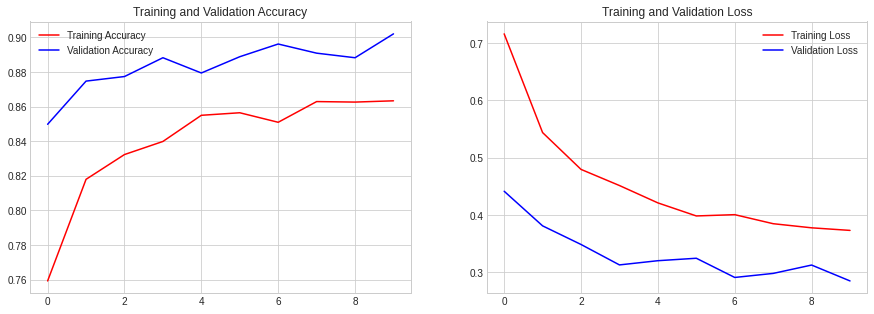

In [ ]:
plot_history(history)

### Evaluate

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['buildings',
                'forest',
                'mountain',
                'glacier',
                'sea',
                'street']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 3407 images belonging to 6 classes.


Confusion Matrix
[[782   4   2   2   8  46]
 [  1 465   1   2   2   3]
 [  1   4 478  41  26   3]
 [  1   2  98 409  14   1]
 [  5   1   8   5 489   2]
 [ 40   0   2   3   6 450]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.93       844
      forest       0.98      0.98      0.98       474
    mountain       0.81      0.86      0.84       553
     glacier       0.89      0.78      0.83       525
         sea       0.90      0.96      0.93       510
      street       0.89      0.90      0.89       501

    accuracy                           0.90      3407
   macro avg       0.90      0.90      0.90      3407
weighted avg       0.90      0.90      0.90      3407



### Save

In [ ]:
model.save_weights('model_weights.h5')
model.save('model.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Predict

## Function

In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['buildings',
          'forest',
          'mountain',
          'glacier',
          'sea',
          'street']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'buildings'
  elif predict_label == 1:
      predict_product = 'forest'
  elif predict_label == 2:
      predict_product = 'mountain'
  elif predict_label == 3:
      predict_product = 'glacier'
  elif predict_label == 4:
      predict_product = 'sea'
  else:
      predict_product = 'street'

  return predict_product, df

## Predict Image

In [ ]:
def predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

  label, df = predict_image(img)

  print('\n')
  plt.show()
  print("\nThe image is detected as " + label)
  print('\n')
  print(df)
  print('\n')

Saving 6.jpg to 6.jpg




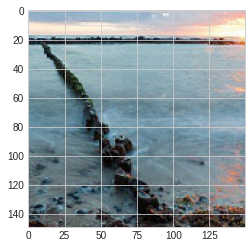


The image is detected as sea


     Product   Probability
0  buildings  1.915073e-04
1     forest  3.033083e-07
2   mountain  3.015116e-03
3    glacier  1.442201e-03
4        sea  9.946777e-01
5     street  6.732951e-04




In [ ]:
predict()